#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [1]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisiert Daten auf [-1, 1]
])


# create an instance of the training split of the FashionMNIST dataset
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, transform=transform, target_transform=lambda x: torch.Tensor([x]).int())
# now create an instance of the test split
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, transform=transform, target_transform=lambda x: torch.Tensor([x]).int())
# for our purposes we can combine the 60k training and 10k testing samples
dataset = ConcatDataset([dataset_train, dataset_valid])
# display some information on the dataset
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=2048,
                                          shuffle=True, num_workers=2)

print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

Using device cuda
The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


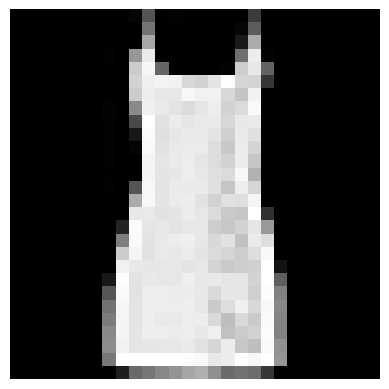

The image shows an instance of Dress.


In [3]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [4]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [5]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule

# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    eps = torch.empty_like(image).normal_(mean=0,std=1)
    noise = eps * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise, eps

def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

def x_forward_steps(curr_image, alpha_quer):
    alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device
    std = torch.sqrt(1 - alpha_quer)
    mean = torch.sqrt(alpha_quer) * curr_image
    new_image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return new_image, eps

def mache_noise_direkt_random(batch_images, total_steps=1000, device=device):
    # Verschieben Sie den Batch auf die GPU
    batch_images = batch_images.to(device)
    
    # Annahme: batch_images hat die Form [batch_size, channels, height, width]
    batch_size = batch_images.size(0)
    
    alpha_quer_list = berechne_alpha_quer_x_forward_steps(total_steps)
    alpha_quer = torch.tensor(alpha_quer_list, device=device)

    noisy_batch = []
    epsilons = []
    anzahl_steps_array = np.empty(batch_size)
    # for loop vernichten
    for i in range(batch_size):
        anzahl_steps = np.random.randint(total_steps)
        anzahl_steps_array[i] = anzahl_steps
        
        image = batch_images[i]
        noisy_image, eps = x_forward_steps(image.unsqueeze(0).to(device), alpha_quer[anzahl_steps-1])  # Verschieben auf die GPU
        
        noisy_batch.append(noisy_image)
        epsilons.append(eps)
    
    noisy_batch_tensor = torch.cat(noisy_batch, dim=0).to(device)  # Verschieben auf die GPU
    epsilons_tensor = torch.cat(epsilons, dim=0).to(device)  # Verschieben auf die GPU
    
    return noisy_batch_tensor, epsilons_tensor, anzahl_steps_array


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv2 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc1 = nn.Linear(128 * 4, 128)
        #self.fc2 = nn.Linear(128, 84)
        #self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



In [7]:
def ResNetWithParam(img_channel=1, num_classes=10):
    return ResNet(ResidualBlock, [3, 4, 23, 3], img_channel, num_classes)

In [8]:
def test():
    BATCH_SIZE = 2048
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetWithParam(img_channel=1, num_classes=10).to(device)
    y = net(torch.randn(BATCH_SIZE, 1, 28, 28, device=device))
    assert y.size() == torch.Size([BATCH_SIZE, 10])
    print(y.size())

In [9]:
test()

torch.Size([2048, 10])


In [10]:
model = torch.load("Fashion_MNIST_Res_Noise.pt")
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv2): Conv2d(256, 64, ker

In [11]:
learning_rate = 0.01
#model = ResNetWithParam(img_channel=1, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)


In [12]:
from tqdm.auto import tqdm

In [13]:
min_loss = 1e25
for epoch in range(0):
    running_loss = 0.0
    model.train()
    mean_epoch_loss = []
    for i, data in tqdm(enumerate(trainloader, 0)):
    # get the inputs; data is a list of [inputs, labels]
        img_tensors, class_labels = [t.to(device) for t in data]
        class_labels = class_labels.squeeze(1).long()
        noisy_image_tensor, eps, anzahl_schritte = mache_noise_direkt_random(img_tensors)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(noisy_image_tensor)
        loss = criterion(outputs, class_labels)
        mean_epoch_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    loss_mean = np.mean(mean_epoch_loss)
    scheduler.step(loss_mean)
    if loss_mean < min_loss:
        min_loss = loss_mean
        #torch.save(model, 'Fashion_MNIST_Res_Noise.pt')
    if epoch%5==0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss: {loss_mean} | Best Loss: {min_loss}")    
        
print('Finished Training')

Finished Training


In [14]:
model = torch.load("Fashion_MNIST_Res_Noise.pt")
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv2): Conv2d(256, 64, ker

T-shirt/top: 0.09337488805072981
Trouser: 0.06475610740835834
Pullover: 0.10202237602429254
Dress: 0.07888087198080156
Coat: 0.10681561524972427
Sandal: 0.08649740361465984
Shirt: 0.10731492409890513
Sneaker: 0.07493006484781822
Bag: 0.1955868567190292
Ankle boot: 0.08982089200568111
Prediction: Bag, Reality: T-shirt/top


/tmp/ipykernel_232913/1577260930.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device


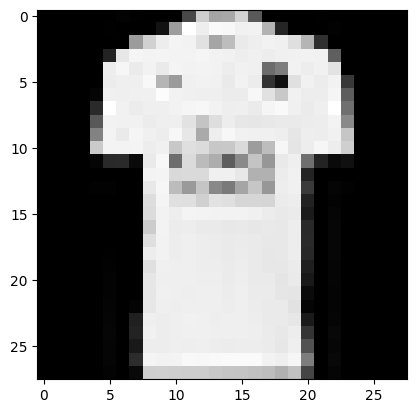

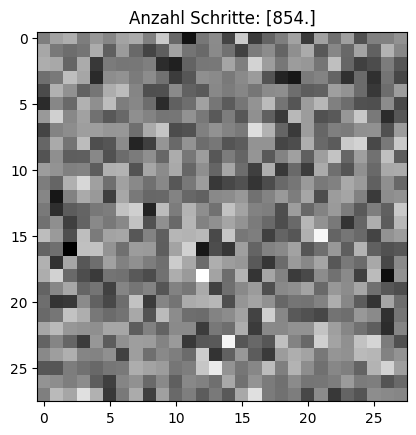

In [39]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

model.eval()
z = np.random.randint(10000)
data_sample = dataset_valid.__getitem__(z)
inp_img, target = [t.to(device) for t in data_sample]
eingabe_bild, eps, anzahl_schritte = mache_noise_direkt_random(inp_img)
out = model(eingabe_bild.unsqueeze(0))
i = 0
temp = out.cpu().detach().numpy().tolist()
x_norm = softmax(temp)
for klasse in dataset_valid.classes:
    print(f'{klasse}: {x_norm[0][i]}')
    i +=1

print(f"Prediction: {dataset_valid.classes[out.argmax().cpu()]}, Reality: {dataset_valid.classes[target.item()]}")
plt.imshow(inp_img.squeeze().cpu(), cmap='Greys_r')
plt.show()

plt.imshow(eingabe_bild.squeeze().cpu(), cmap="gray")
plt.title(f"Anzahl Schritte: {anzahl_schritte}")
plt.show()
